# 🔁 Modelo de Percolación: r-step y s-step
Este notebook implementa el modelo de percolación sobre triangulaciones causales usando dos pasos:

- **r-step**: propagación vertical (entre capas)
- **s-step**: propagación horizontal (en la misma capa)

=== Resumen por nivel ===
Nivel  0: |V|=  1   spine=   0   labels=[1]
  Strip 0->1: k_list=[4]
Nivel  1: |V|=  4   spine=   1   labels=[1, 1, 1, 1]
  Strip 1->2: k_list=[8, 0, 0, 1]
Nivel  2: |V|=  9   spine=   8   labels=[1, 1, 1, 1, 1, 1, 1, 1, 1]
  Strip 2->3: k_list=[1, 5, 1, 2, 0, 3, 1, 2, 0]
Nivel  3: |V|= 15   spine=  22   labels=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  Strip 3->4: k_list=[1, 1, 1, 4, 3, 7, 0, 0, 3, 1, 0, 0, 7, 1, 3]
Nivel  4: |V|= 32   spine=  48   labels=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  Strip 4->5: k_list=[0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 3, 1, 0, 2, 1, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0]
Nivel  5: |V|= 18   spine=  72   labels=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  Strip 5->6: k_list=[0, 0, 0, 1, 1, 1, 5, 0, 2, 0, 0, 6, 3, 1, 1, 5, 1, 1]
Nivel  6: |V|= 28   spine=  90   labels=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

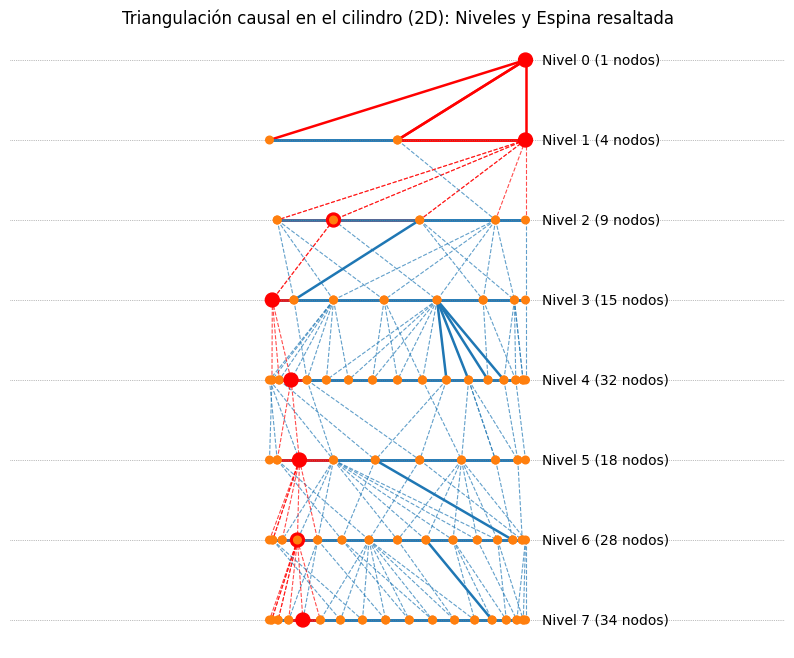

Generando gráfica 3D básica...


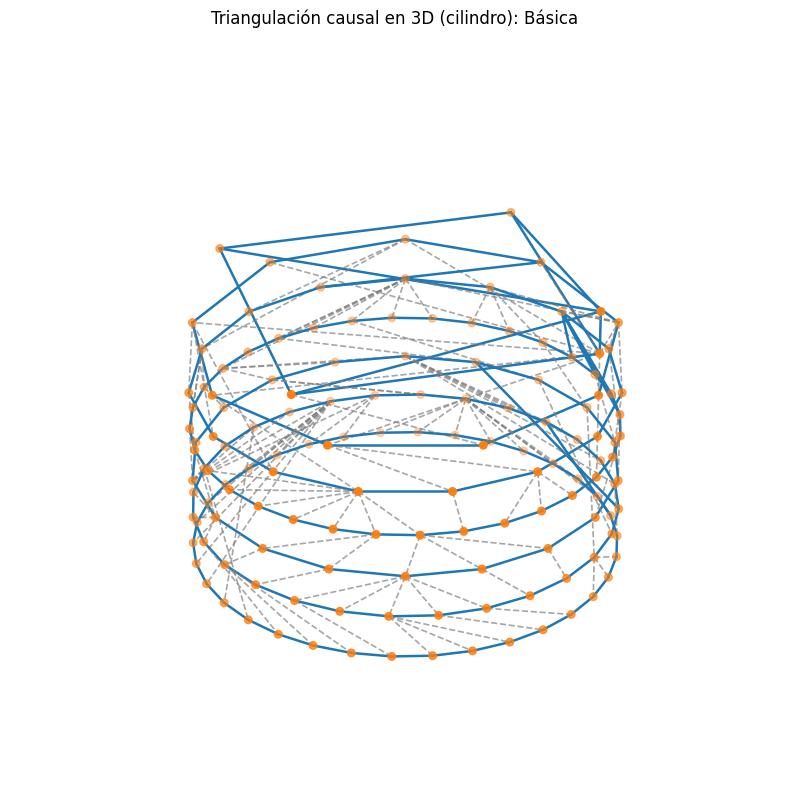

Generando gráfica 3D mejorada...


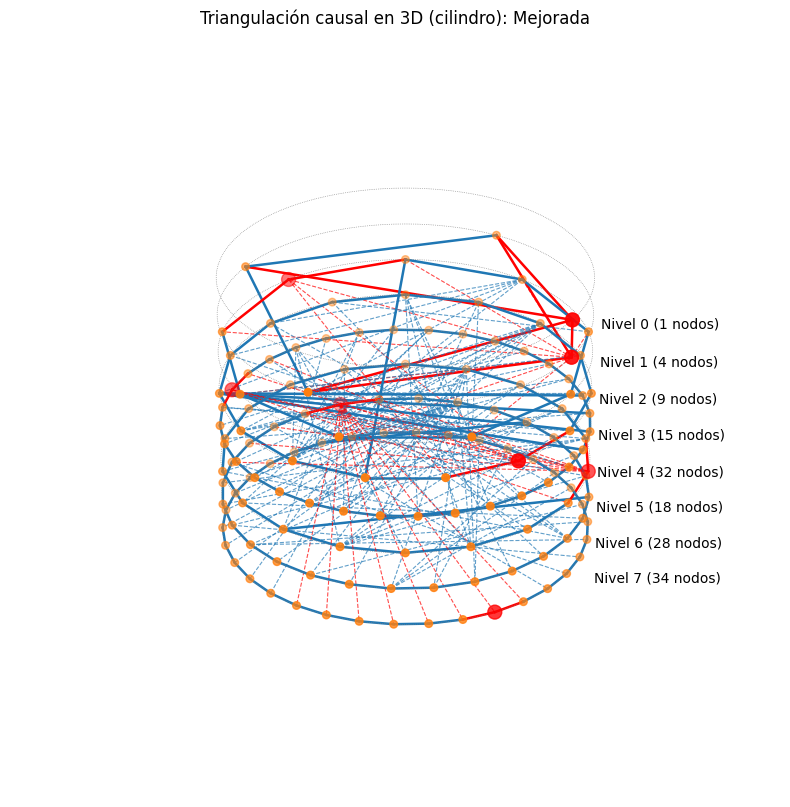


Listo: g, r, s implementados y graficados.


In [8]:
# =========================================================
#   Percolación en Triangulaciones Causales (GW + spine)
#   Implementación fiel al documento con g, r, s + gráficos
# =========================================================

from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 0) Utilidades: muestreos pk y rho, y Union-Find (DSU)
# ---------------------------------------------------------

def sample_pk(rng: np.random.Generator) -> int:
    """
    pk = 1 / 2^{k+1}, k >= 0  (geométrica base con p=1/2)
    Equivale a: Geometric(0.5) - 1
    """
    return rng.geometric(p=0.5) - 1

def sample_rho(rng: np.random.Generator) -> int:
    """
    rho_k = k / 2^{k+1}, k >= 1  (sesgada por tamaño)
    Muestreo por inversa de la CDF: F(n) = 1 - (n+2)/2^{n+1}
    """
    u = rng.random()
    n = 1
    while True:
        if u <= 1 - (n + 2) / (2 ** (n + 1)):
            return n
        n += 1

class DSU:
    """Disjoint Set Union para fusionar componentes (clusters)."""
    def __init__(self, n: int):
        self.parent = list(range(n))
        self.rank = [0]*n

    def find(self, x: int) -> int:
        while self.parent[x] != x:
            self.parent[x] = self.parent[self.parent[x]]
            x = self.parent[x]
        return x

    def union(self, a: int, b: int):
        ra, rb = self.find(a), self.find(b)
        if ra == rb:
            return
        if self.rank[ra] < self.rank[rb]:
            self.parent[ra] = rb
        elif self.rank[ra] > self.rank[rb]:
            self.parent[rb] = ra
        else:
            self.parent[rb] = ra
            self.rank[ra] += 1


# ---------------------------------------------------------
# 1) g–step: Generación por niveles con “spine decomposition”
#    - Spine (root actual) ~ rho
#    - No-spine ~ pk
#    - Nuevo spine: hijo elegido uniforme entre los hijos del spine
#    Registros:
#      * layers[i]: IDs globales en el nivel i (orden contiguo por padre)
#      * spine_ids[i]: ID del spine en el nivel i (o -1)
#      * splits[i]: [k_1,...,k_m] hijos por padre en el strip i->i+1
# ---------------------------------------------------------

def generate_layers_with_splits(n_layers: int = 7, rng: np.random.Generator = np.random.default_rng()):
    rng_g = np.random.default_rng(rng.integers(0, 1000000)) # Use a sub-seed for reproducibility if needed, or just use the main rng

    layers: List[List[int]] = [[0]]  # nivel 0: raíz id 0
    spine_ids: List[int] = [0]       # spine en nivel 0
    splits: List[List[int]] = []     # por strip i->i+1
    next_node_id = 1

    # Nivel 0: la raíz (spine) usa rho
    k0 = sample_rho(rng_g)
    splits.append([k0])
    level1 = list(range(next_node_id, next_node_id + k0))
    next_node_id += k0
    layers.append(level1)
    new_spine = level1[rng_g.integers(0, k0)] if k0 > 0 else -1
    spine_ids.append(new_spine)

    # Niveles siguientes
    for i in range(1, n_layers):
        parents = layers[i]
        if len(parents) == 0:
            if i < n_layers - 1:
                splits.append([])
            spine_ids.append(-1)
            layers.append([])
            continue

        split_this_strip: List[int] = []
        next_level: List[int] = []
        spine_id = spine_ids[i]

        for parent in parents:
            if parent == spine_id and spine_id != -1:
                k = sample_rho(rng_g)  # spine -> rho
            else:
                k = sample_pk(rng_g)   # no-spine -> pk
            split_this_strip.append(k)

            children = list(range(next_node_id, next_node_id + k))
            next_node_id += k
            next_level.extend(children)

        splits.append(split_this_strip)
        layers.append(next_level)

        # Elegir nuevo spine si el spine actual tuvo hijos
        if spine_id != -1:
            idx_spine_parent = parents.index(spine_id)
            k_sp = split_this_strip[idx_spine_parent]
            start = sum(split_this_strip[:idx_spine_parent])
            new_spine = next_level[start + rng_g.integers(0, k_sp)] if k_sp > 0 else -1
        else:
            new_spine = -1
        spine_ids.append(new_spine)

    return layers, spine_ids, splits


# ---------------------------------------------------------
# 2) Topología de la triangulación (sin percolación aún)
#    - Estructura del strip i->i+1: tiempo y auxiliares
#    - Anillo de espacio en cada nivel
#    Representamos nodos como tuplas (nivel, id_global)
# ---------------------------------------------------------

def partition_children_by_parents(children: List[int], k_list: List[int]) -> List[List[int]]:
    groups, pos = [], 0
    for k in k_list:
        groups.append(children[pos:pos+k])
        pos += k
    return groups

def strip_edges(parents: List[int], children: List[int], k_list: List[int]):
    """Aristas de TIEMPO (padre->hijo) y AUXILIARES (entre hijos de padres consecutivos) en el strip i->i+1."""
    time_edges: List[Tuple[int, int]] = []
    aux_edges: List[Tuple[int, int]] = []
    if len(parents) == 0 or len(children) == 0:
        return time_edges, aux_edges

    groups = partition_children_by_parents(children, k_list)

    # Tiempo
    for j, p in enumerate(parents):
        for c in groups[j]:
            time_edges.append((p, c))

    # Auxiliares (cierre entre grupos contiguos con hijos; circular)
    m = len(parents)
    if m >= 2:
        for j in range(m):
            if len(groups[j]) == 0:
                continue
            last_c = groups[j][-1]
            s = (j + 1) % m
            while s != j and len(groups[s]) == 0:
                s = (s + 1) % m
            if s != j and len(groups[s]) > 0:
                first_next = groups[s][0]
                aux_edges.append((last_c, first_next))
    return time_edges, aux_edges

def space_ring(level_nodes: List[int]) -> List[Tuple[int, int]]:
    """Anillo en nivel i: vecinos y cierre circular."""
    m = len(level_nodes)
    if m < 2:
        return []
    out = []
    for i in range(m):
        out.append((level_nodes[i], level_nodes[(i+1) % m]))
    return out

def triangulate_layers_exact(layers: List[List[int]], splits: List[List[int]]):
    """
    Construye TODAS las aristas (como pares ((i,id),(j,id))):
      - tiempo, auxiliares y espacio. Devuelve también separadas por tipo.
    """
    levels = [list(lvl) for lvl in layers]  # copia
    time_e_all, aux_e_all, space_e_all = [], [], []

    # Espacio en todos los niveles
    for i, lvl in enumerate(levels):
        for (a, b) in space_ring(lvl):
            space_e_all.append(((i, a), (i, b)))

    # Strip por strip
    for i in range(len(levels)-1):
        parents, children = levels[i], levels[i+1]
        k_list = splits[i] if i < len(splits) else [0]*len(parents)
        t_e, a_e = strip_edges(parents, children, k_list)
        for (p, c) in t_e:
            time_e_all.append(((i, p), (i+1, c)))
        for (c1, c2) in a_e:
            aux_e_all.append(((i+1, c1), (i+1, c2)))

    edges_all = sorted(set(time_e_all) | set(aux_e_all) | set(space_e_all))
    return edges_all, levels, time_e_all, aux_e_all, space_e_all


# ---------------------------------------------------------
# 3) r–step: Bernoulli(p) en TIEMPO y AUXILIARES del strip i->i+1
#    - Propaga colores del nivel i al i+1 por aristas de TIEMPO abiertas
#    - Fusiona hijos de distintos padres por AUXILIARES abiertas
# ---------------------------------------------------------

def r_step_update(
    v_prev: List[int],          # etiquetas en nivel i (mismo orden que layers[i])
    parents: List[int],         # ids en nivel i
    children: List[int],        # ids en nivel i+1
    k_list: List[int],          # split por padre en strip i->i+1
    p: float,
    rng: np.random.Generator,
) -> Tuple[List[int], List[Tuple[Tuple[int,int], Tuple[int,int]]]]:
    """
    Devuelve:
      - v_next preliminar (len= len(children), orden de layers[i+1])
      - lista de aristas ABIERTAS en este r-step (como pares ((i,id),(j,id)))
    """
    open_edges_r = []

    L = len(children)
    if L == 0:
        return [], open_edges_r

    # índice en el nivel i+1
    idx_child = {cid: j for j, cid in enumerate(children)}
    # etiqueta inicial distinta por hijo (será sobreescrita/fusionada)
    v_next = [j+1 for j in range(L)]
    dsu = DSU(L)

    # construir aristas del strip (nivel puro, sin empaquetar en tuplas aún)
    t_e, a_e = strip_edges(parents, children, k_list)

    # TIEMPO: si abre, el hijo hereda color del padre
    pos_parent = {pid: j for j, pid in enumerate(parents)}
    for (p_id, c_id) in t_e:
        if rng.random() < p:
            j_parent = pos_parent[p_id]
            j_child = idx_child[c_id]
            v_next[j_child] = v_prev[j_parent]
            # (i,p) -> (i+1,c) - Usamos el nivel del padre para la primera coordenada
            open_edges_r.append(((pos_parent[p_id], parents[j_parent]), (pos_parent[p_id]+1, c_id)))

    # AUXILIARES: si abre, fusiona hijos
    for (c1, c2) in a_e:
        if rng.random() < p:
            i1, i2 = idx_child[c1], idx_child[c2]
            dsu.union(i1, i2)
            # arista abierta en (i+1) - Usamos el nivel del padre para la primera coordenada, aunque la arista sea en i+1
            if parents: # Ensure parents list is not empty before accessing index 0
                 open_edges_r.append(((pos_parent[parents[0]]+1, c1), (pos_parent[parents[0]]+1, c2)))
            else:
                 # Handle cases where parents list is empty, perhaps skip this edge or log a warning
                 pass


    # compactar etiquetas por clases del DSU (min etiqueta en la clase)
    root_min = {}
    for j in range(L):
        r = dsu.find(j)
        root_min.setdefault(r, v_next[j])
        root_min[r] = min(root_min[r], v_next[j])
    out = v_next[:] # Create a copy to avoid modifying v_next in place
    for j in range(L):
        out[j] = root_min[dsu.find(j)]

    return out, open_edges_r


# ---------------------------------------------------------
# 4) s–step: Bernoulli(p) en ESPACIO (anillo) del nivel i+1
#    - Fusiona vecinos del anillo que se abren
# ---------------------------------------------------------

def s_step_update(
    v_next: List[int],          # etiquetas tras r-step, orden de layers[i+1]
    children_level: List[int],  # ids de layers[i+1] en orden
    p: float,
    rng: np.random.Generator,
    level_index: int            # índice del nivel i+1 (solo para etiquetar aristas)
) -> Tuple[List[int], List[Tuple[Tuple[int,int], Tuple[int,int]]]]:
    open_edges_s = []
    L = len(v_next)
    if L <= 1:
        return v_next[:], open_edges_s

    dsu = DSU(L)
    for i in range(L):
        j = (i + 1) % L
        if rng.random() < p:
            dsu.union(i, j)
            # registrar arista abierta en el nivel level_index (espacio)
            open_edges_s.append(((level_index, children_level[i]), (level_index, children_level[j])))

    # compactar etiquetas por clase (min)
    root_min = {}
    for i in range(L):
        r = dsu.find(i)
        root_min.setdefault(r, v_next[i])
        root_min[r] = min(root_min[r], v_next[i])
    out = v_next[:]
    for i in range(L):
        out[i] = root_min[dsu.find(i)]
    return out, open_edges_s


# ---------------------------------------------------------
# 5) Simulación completa g + (r,s) y construcción de aristas abiertas
# ---------------------------------------------------------

@dataclass
class SimulationResult:
    layers: List[List[int]]
    spine_ids: List[int]
    splits: List[List[int]]
    cluster_labels: List[List[int]]   # etiquetas finales por nivel (orden layers[i])
    edges_all: List[Tuple[Tuple[int,int], Tuple[int,int]]]  # todas las aristas (tiempo/aux/espacio)
    open_edges: List[Tuple[Tuple[int,int], Tuple[int,int]]] # subconjunto de edges_all que quedaron abiertas (r+s)

def simulate_and_build_edges(
    n_layers: int = 7,
    p_perc: float = 0.5,
    rng: np.random.Generator = np.random.default_rng()
) -> SimulationResult:
    # g-step
    layers, spine_ids, splits = generate_layers_with_splits(n_layers=n_layers, rng=rng)

    # Topología completa (tiempo, auxiliares, espacio)
    edges_all, levels, time_e_all, aux_e_all, space_e_all = triangulate_layers_exact(layers, splits)

    # Etiquetas de clusters: nivel 0
    cluster_labels: List[List[int]] = [[1]]  # raíz
    open_edges: List[Tuple[Tuple[int,int], Tuple[int,int]]] = []

    # Strip por strip
    for i in range(len(layers)-1):
        parents = layers[i]
        children = layers[i+1]
        k_list = splits[i] if i < len(splits) else [0]*len(parents)
        v_prev = cluster_labels[i]

        # r-step (tiempo+aux)
        v_next_pre, open_r = r_step_update(v_prev, parents, children, k_list, p_perc, rng)
        open_edges.extend(open_r)

        # s-step (espacio)
        v_next, open_s = s_step_update(v_next_pre, children, p_perc, rng, level_index=i+1)
        open_edges.extend(open_s)

        cluster_labels.append(v_next)

    return SimulationResult(
        layers=layers,
        spine_ids=spine_ids,
        splits=splits,
        cluster_labels=cluster_labels,
        edges_all=edges_all,
        open_edges=open_edges
    )


# =========================================================
# 6) Gráficos: cilindro 2D/3D con aristas abiertas (—) y cerradas (--)
#     (Se reutiliza tu interfaz; usa open_edges de r+s)
# =========================================================

def draw_cylinder_percolation_2d(levels, edges_all, open_edges, node_marker=None, spine_ids=None):
    """
    Dibuja niveles sobre circunferencias apiladas:
      - Aristas abiertas: línea continua
      - Aristas cerradas: línea punteada
      - Resalta aristas incidentes a la espina en rojo
    """
    # Posiciones por nivel en círculo
    pos = {}
    y_gap = 2.5
    R = 4.0
    for d, lvl in enumerate(levels):
        m = max(len(lvl), 1)
        thetas = np.linspace(0, 2*np.pi, m, endpoint=False) if m > 1 else np.array([0.0])
        for j, gid in enumerate(lvl):
            x = R * np.cos(thetas[j])
            y = -d * y_gap
            pos[(d, gid)] = (x, y)

    open_set = set(tuple(sorted(e)) for e in open_edges)

    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Conjunto de nodos espina
    spine_nodes_set = set()
    if spine_ids and levels:
        for d, s_id in enumerate(spine_ids):
            if d < len(levels) and s_id in levels[d] and s_id != -1:
                spine_nodes_set.add((d, s_id))

    # Aristas
    for a, b in edges_all:
        if a not in pos or b not in pos: # Skip edges with nodes not in pos (e.g., if levels were empty)
             continue
        x1, y1 = pos[a]; x2, y2 = pos[b]
        edge_color = 'red' if a in spine_nodes_set or b in spine_nodes_set else 'C0'
        linestyle = '-' if tuple(sorted((a, b))) in open_set else '--'
        linewidth = 1.8 if linestyle == '-' else 0.8
        ax.plot([x1, x2], [y1, y2], linestyle=linestyle, linewidth=linewidth, color=edge_color, alpha=0.7 if linestyle == '--' else 1.0)

    # Nodos
    xs, ys, ss, node_colors = [], [], [], []
    for d, lvl in enumerate(levels):
        for gid in lvl:
            node_key = (d, gid)
            if node_key in pos:
                x, y = pos[node_key]
                xs.append(x); ys.append(y)
                if node_key in spine_nodes_set:
                    ss.append(100); node_colors.append('red')
                else:
                    ss.append(30);  node_colors.append('C1')

    ax.scatter(xs, ys, s=ss, zorder=3, c=node_colors)

    # Líneas horizontales y etiquetas de nivel
    for d in range(len(levels)):
        y_level = -d * y_gap
        num_nodes_in_level = len(levels[d])
        ax.axhline(y_level, color='gray', linestyle=':', linewidth=0.5)
        ax.text(R + 0.5, y_level, f'Nivel {d} ({num_nodes_in_level} nodos)', color='black', fontsize=10, va='center')

    plt.title("Triangulación causal en el cilindro (2D): Niveles y Espina resaltada")
    plt.axis('equal'); plt.axis('off')
    plt.show()


def draw_cylinder_percolation_3d_basic(levels, edges_all, open_edges, node_marker=None):
    """Dibujo 3D simple sobre cilindro, con aristas abiertas/ cerradas."""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    pos_3d = {}
    y_gap = 2.0
    R = 3.0
    for d, lvl in enumerate(levels):
        m = max(len(lvl), 1)
        thetas = np.linspace(0, 2*np.pi, m, endpoint=False) if m > 1 else np.array([0.0])
        for j, gid in enumerate(lvl):
            x = R * np.cos(thetas[j])
            y = R * np.sin(thetas[j])
            z = -d * y_gap
            pos_3d[(d, gid)] = (x, y, z)

    open_set = set(tuple(sorted(e)) for e in open_edges)

    # Aristas
    for a, b in edges_all:
        if a in pos_3d and b in pos_3d:
            x1, y1, z1 = pos_3d[a]
            x2, y2, z2 = pos_3d[b]
            xs = [x1, x2]; ys = [y1, y2]; zs = [z1, z2]
            if tuple(sorted((a, b))) in open_set:
                ax.plot(xs, ys, zs, linestyle='-', linewidth=1.8, color='C0')
            else:
                ax.plot(xs, ys, zs, linestyle='--', linewidth=1.2, color='grey', alpha=0.7)

    # Nodos
    xs, ys, zs, ss = [], [], [], []
    for d, lvl in enumerate(levels):
        for gid in lvl:
            if (d, gid) in pos_3d:
                x, y, z = pos_3d[(d, gid)]
                xs.append(x); ys.append(y); zs.append(z); ss.append(30)
    ax.scatter(xs, ys, zs, s=ss, zorder=3, color='C1')

    ax.set_title("Triangulación causal en 3D (cilindro): Básica", y=1.08)
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.axis('off')
    plt.show()


def draw_cylinder_percolation_3d_improved(levels, edges_all, open_edges, node_marker=None, spine_ids=None):
    """Dibujo 3D mejorado: coloca ángulos según padres (aprox.) y resalta espina."""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    pos_3d = {}
    y_gap = 2.0
    R = 3.0

    # Semilla: nodo raíz
    if levels and levels[0]:
        pos_3d[(0, levels[0][0])] = (R * np.cos(0), R * np.sin(0), 0)

    # Mapa padre->hijos (solo por aristas de tiempo)
    parent_child_map = defaultdict(list)
    child_parent_map = {}
    for a, b in edges_all:
        if b[0] == a[0] + 1 and a[0] >= 0:
            parent_child_map[a].append(b); child_parent_map[b] = a
        elif a[0] == b[0] + 1 and b[0] >= 0:
            parent_child_map[b].append(a); child_parent_map[a] = b

    # Posiciones por niveles
    for d in range(1, len(levels)):
        current_level = levels[d]
        if not current_level:
            continue
        desired_angles = {}
        for gid in current_level:
            node_key = (d, gid)
            if node_key in child_parent_map and child_parent_map[node_key] in pos_3d:
                px, py, _ = pos_3d[child_parent_map[node_key]]
                desired_angles[node_key] = np.arctan2(py, px)
            else:
                desired_angles[node_key] = 0.0
        sorted_nodes = sorted(desired_angles.keys(), key=lambda k: desired_angles[k])
        assigned = np.linspace(0, 2*np.pi, len(sorted_nodes), endpoint=False)
        for i, nk in enumerate(sorted_nodes):
            angle = assigned[i]
            pos_3d[nk] = (R*np.cos(angle), R*np.sin(angle), -d*y_gap)

    open_set = set(tuple(sorted(e)) for e in open_edges)

    # Conjunto espina
    spine_nodes_set = set()
    if spine_ids and levels:
        for d, s_id in enumerate(spine_ids):
            if d < len(levels) and s_id in levels[d] and s_id != -1:
                spine_nodes_set.add((d, s_id))

    # Dibujar aristas
    for a, b in edges_all:
        if a in pos_3d and b in pos_3d:
            x1, y1, z1 = pos_3d[a]; x2, y2, z2 = pos_3d[b]
            xs = [x1, x2]; ys = [y1, y2]; zs = [z1, z2]
            edge_color = 'red' if a in spine_nodes_set or b in spine_nodes_set else 'C0'
            linestyle = '-' if tuple(sorted((a, b))) in open_set else '--'
            linewidth = 1.8 if linestyle == '-' else 0.8
            ax.plot(xs, ys, zs, linestyle=linestyle, linewidth=linewidth, color=edge_color, alpha=0.7 if linestyle == '--' else 1.0)

    # Nodos
    xs, ys, zs, ss, cs = [], [], [], [], []
    for d, lvl in enumerate(levels):
        for gid in lvl:
            nk = (d, gid)
            if nk in pos_3d:
                x, y, z = pos_3d[nk]
                xs.append(x); ys.append(y); zs.append(z)
                if nk in spine_nodes_set:
                    ss.append(100); cs.append('red')
                else:
                    ss.append(30);  cs.append('C1')
    ax.scatter(xs, ys, zs, s=ss, zorder=3, c=cs)

    # Círculos de nivel y etiquetas
    for d in range(len(levels)):
        z = -d*y_gap
        theta = np.linspace(0, 2*np.pi, 100)
        ax.plot(R*np.cos(theta), R*np.sin(theta), z, color='gray', linestyle=':', linewidth=0.5)
        ax.text(R+0.5, 0, z, f'Nivel {d} ({len(levels[d])} nodos)', color='black', fontsize=10)

    ax.set_title("Triangulación causal en 3D (cilindro): Mejorada", y=1.08)
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.axis('off')
    max_depth = len(levels)-1 if levels else 0
    ax.set_zlim(-(max_depth* y_gap)-y_gap, y_gap)
    ax.set_xlim(-R-1, R+1); ax.set_ylim(-R-1, R+1)
    plt.show()


# ---------------------------------------------------------
# 7) Demo: correr simulación, obtener edges abiertas, y graficar
# ---------------------------------------------------------

if __name__ == "__main__":
    # Parámetros
    n_layers = 7
    p_perc   = 1
    # No se especifica semilla para que sea aleatoria cada vez
    rng = np.random.default_rng()

    # Simular (g + r + s) y construir aristas abiertas/cerradas
    res = simulate_and_build_edges(n_layers=n_layers, p_perc=p_perc, rng=rng)

    print("=== Resumen por nivel ===")
    for i, lvl in enumerate(res.layers):
        spine = res.spine_ids[i] if i < len(res.spine_ids) else -1
        labels = res.cluster_labels[i] if i < len(res.cluster_labels) else []
        print(f"Nivel {i:>2}: |V|={len(lvl):>3}   spine={spine:>4}   labels={labels}")
        if i < len(res.splits):
            print(f"  Strip {i}->{i+1}: k_list={res.splits[i]}")

    # Preparar marcadores de espina (opcional, para colorear nodos)
    node_marker = {}
    for d, lvl in enumerate(res.layers):
        s_id = res.spine_ids[d] if d < len(res.spine_ids) else -1
        for gid in lvl:
            node_marker[(d, gid)] = {'espina': (gid == s_id)}

    # Dibujos
    print("\nGenerando gráfica 2D...")
    draw_cylinder_percolation_2d(
        levels=res.layers,
        edges_all=res.edges_all,
        open_edges=res.open_edges,
        node_marker=node_marker,
        spine_ids=res.spine_ids
    )

    print("Generando gráfica 3D básica...")
    draw_cylinder_percolation_3d_basic(
        levels=res.layers,
        edges_all=res.edges_all,
        open_edges=res.open_edges,
        node_marker=node_marker
    )

    print("Generando gráfica 3D mejorada...")
    draw_cylinder_percolation_3d_improved(
        levels=res.layers,
        edges_all=res.edges_all,
        open_edges=res.open_edges,
        node_marker=node_marker,
        spine_ids=res.spine_ids
    )

    print("\nListo: g, r, s implementados y graficados.")